In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import data

In [2]:
#btc options data
df=pd.read_csv('data/btc_data.csv', sep=",", index_col=0)

#df.drop(columns=['Unnamed: 0', 'interest_rate'], inplace=True)


In [3]:
df

,best_ask_amount,bid_iv,ask_iv,underlying_index,underlying_price,mark_iv,interest_rate,best_bid_price,best_ask_price,open_interest,...,greeks.theta,greeks.vega,greeks.gamma,greeks.delta,stats.volume_usd,stats.volume,stats.price_change,stats.low,stats.high,settlement_period
best_bid_amount,,,,,,,,,,,,,,,,,,,,,
0.0,20.7,0.00,151.10,SYN.BTC-4FEB24,43046.8715,85.49,0.0,0.0000,0.1070,0.0,...,-4.77329,0.11167,0.00000,0.99820,0.00,0.0,NaN,NaN,NaN,day
0.0,92.5,0.00,110.01,SYN.BTC-4FEB24,43046.6290,85.49,0.0,0.0000,0.0002,1.0,...,-0.87260,0.11172,0.00000,-0.00180,0.00,0.0,NaN,NaN,NaN,day
0.0,19.8,0.00,139.25,SYN.BTC-4FEB24,43046.8715,78.77,0.0,0.0000,0.0955,0.0,...,-6.15599,0.15630,0.00001,0.99740,0.00,0.0,NaN,NaN,NaN,day
0.0,1.5,0.00,90.44,SYN.BTC-4FEB24,43046.8715,78.77,0.0,0.0000,0.0001,30.1,...,-1.19951,0.15630,0.00001,-0.00260,12.92,3.0,0.0000,0.0001,0.0001,day
0.0,20.7,0.00,126.92,SYN.BTC-4FEB24,43046.8715,66.52,0.0,0.0000,0.0840,0.0,...,-4.09321,0.12306,0.00000,0.99800,0.00,0.0,NaN,NaN,NaN,day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.0,0.0,0.00,0.00,BTC-27DEC24,46185.0600,64.49,0.0,0.0000,0.0000,25.0,...,-9.23031,93.81755,0.00001,-0.86748,0.00,0.0,NaN,NaN,NaN,month
16.0,0.1,63.81,65.54,BTC-27DEC24,46185.0600,64.68,0.0,0.0230,0.0260,43.0,...,-7.87169,79.77856,0.00001,0.10536,0.00,0.0,NaN,NaN,NaN,month
0.0,0.0,0.00,0.00,BTC-27DEC24,46185.0600,64.68,0.0,0.0000,0.0000,0.0,...,-7.87169,79.77856,0.00001,-0.89464,3482680.18,50.0,-0.2233,1.6088,1.6124,month


### Extract Expiration date and strike price

In [4]:
import pandas as pd
import re

# Define a function to extract expiration date and strike price
def extract_details(instrument_name):
    match = re.match(r"BTC-(\d+[A-Z]{3}\d+)-(\d+)-[CP]", instrument_name)
    if match:
        expiration_date = match.group(1)
        strike_price = match.group(2)
        return expiration_date, strike_price
    return None, None

# Apply the function to your data
df['Expiration Date'], df['Strike Price'] = zip(*df['instrument_name'].apply(extract_details))

# Check the updated DataFrame
print(df[['instrument_name', 'Expiration Date', 'Strike Price']])


                      instrument_name Expiration Date Strike Price
best_bid_amount                                                   
0.0                BTC-4FEB24-38500-C          4FEB24        38500
0.0                BTC-4FEB24-38500-P          4FEB24        38500
0.0                BTC-4FEB24-39000-C          4FEB24        39000
0.0                BTC-4FEB24-39000-P          4FEB24        39000
0.0                BTC-4FEB24-39500-C          4FEB24        39500
...                               ...             ...          ...
0.0              BTC-27DEC24-110000-P         27DEC24       110000
16.0             BTC-27DEC24-120000-C         27DEC24       120000
0.0              BTC-27DEC24-120000-P         27DEC24       120000
17.0             BTC-27DEC24-130000-C         27DEC24       130000
0.0              BTC-27DEC24-130000-P         27DEC24       130000

[658 rows x 3 columns]


In [5]:
df.to_csv('data/btc_data.csv')

##### Core Trading Data

* best_bid_amount, best_ask_amount: The quantity available at the best bid and best ask prices.
* best_bid_price, best_ask_price: The highest price buyers are willing to pay (bid) and the lowest price sellers are willing to accept (ask).
* bid_iv, ask_iv: Implied volatility of the best bid and ask.
* underlying_index: The index or ticker symbol of the underlying asset, which in this case is Bitcoin.
* underlying_price: Current price of the underlying asset.
* mark_iv: The market's consensus on implied volatility.
* open_interest: Total number of outstanding derivative contracts, such as options or futures, that have not been settled.
* max_price, min_price: Maximum and minimum prices recorded.
* last_price: The most recent price at which the option was traded.

##### Advanced Trading Metrics
* interest_rate: Interest rate used for pricing options, typically a risk-free rate.
* asks, bids: These might contain more detailed order book data in JSON or another structured format.
* settlement_price: The price used for settling trades at the end of a trading period.
* mark_price: The current market price of the contracts.
* index_price: Index price that the derivative tracks.

##### Timestamps and Changes
* change_id: An identifier for tracking changes to data points.
* timestamp: UNIX timestamp indicating the time of data retrieval.


##### Greeks
* greeks.rho: Sensitivity to the interest rate.
* greeks.theta: Sensitivity to time decay.
* greeks.vega: Sensitivity to changes in the volatility of the underlying asset.
* greeks.gamma: The rate of change of delta with respect to changes in the underlying price.
* greeks.delta: The rate of change of the option's price with respect to changes in the underlying asset's price.

##### Statistical Data
* stats.volume_usd, stats.volume: Trading volume in USD and in units.
* stats.price_change, stats.low, stats.high: Change in price, lowest, and highest price during the recording period.

##### Settlement Information
* settlement_period: The periodicity of settlement, such as daily, weekly, etc.

### Data Cleaning and Preparation

### Bitcoin

In [6]:
df.head()

,best_ask_amount,bid_iv,ask_iv,underlying_index,underlying_price,mark_iv,interest_rate,best_bid_price,best_ask_price,open_interest,...,greeks.gamma,greeks.delta,stats.volume_usd,stats.volume,stats.price_change,stats.low,stats.high,settlement_period,Expiration Date,Strike Price
best_bid_amount,,,,,,,,,,,,,,,,,,,,,
0.0,20.7,0.0,151.10,SYN.BTC-4FEB24,43046.8715,85.49,0.0,0.0,0.1070,0.0,...,0.00000,0.9982,0.00,0.0,NaN,NaN,NaN,day,4FEB24,38500
0.0,92.5,0.0,110.01,SYN.BTC-4FEB24,43046.6290,85.49,0.0,0.0,0.0002,1.0,...,0.00000,-0.0018,0.00,0.0,NaN,NaN,NaN,day,4FEB24,38500
0.0,19.8,0.0,139.25,SYN.BTC-4FEB24,43046.8715,78.77,0.0,0.0,0.0955,0.0,...,0.00001,0.9974,0.00,0.0,NaN,NaN,NaN,day,4FEB24,39000
0.0,1.5,0.0,90.44,SYN.BTC-4FEB24,43046.8715,78.77,0.0,0.0,0.0001,30.1,...,0.00001,-0.0026,12.92,3.0,0.0,0.0001,0.0001,day,4FEB24,39000
0.0,20.7,0.0,126.92,SYN.BTC-4FEB24,43046.8715,66.52,0.0,0.0,0.0840,0.0,...,0.00000,0.9980,0.00,0.0,NaN,NaN,NaN,day,4FEB24,39500


In [7]:
df.columns

Index(['best_ask_amount', 'bid_iv', 'ask_iv', 'underlying_index',
       'underlying_price', 'mark_iv', 'interest_rate', 'best_bid_price',
       'best_ask_price', 'open_interest', 'max_price', 'min_price',
       'last_price', 'asks', 'bids', 'settlement_price', 'instrument_name',
       'mark_price', 'index_price', 'change_id', 'timestamp', 'greeks.rho',
       'greeks.theta', 'greeks.vega', 'greeks.gamma', 'greeks.delta',
       'stats.volume_usd', 'stats.volume', 'stats.price_change', 'stats.low',
       'stats.high', 'settlement_period', 'Expiration Date', 'Strike Price'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 658 entries, 0.0 to 0.0
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   best_ask_amount     658 non-null    float64
 1   bid_iv              658 non-null    float64
 2   ask_iv              658 non-null    float64
 3   underlying_index    658 non-null    object 
 4   underlying_price    658 non-null    float64
 5   mark_iv             658 non-null    float64
 6   interest_rate       658 non-null    float64
 7   best_bid_price      658 non-null    float64
 8   best_ask_price      658 non-null    float64
 9   open_interest       658 non-null    float64
 10  max_price           658 non-null    float64
 11  min_price           658 non-null    float64
 12  last_price          501 non-null    float64
 13  asks                658 non-null    object 
 14  bids                658 non-null    object 
 15  settlement_price    616 non-null    float64
 16  instrument_

In [9]:
#Get descriptive statistics
df.describe()

,best_ask_amount,bid_iv,ask_iv,underlying_price,mark_iv,interest_rate,best_bid_price,best_ask_price,open_interest,max_price,...,greeks.rho,greeks.theta,greeks.vega,greeks.gamma,greeks.delta,stats.volume_usd,stats.volume,stats.price_change,stats.low,stats.high
count,658.000000,658.000000,658.000000,658.000000,658.000000,658.0,658.000000,658.000000,658.000000,658.000000,...,658.000000,658.000000,658.000000,658.000000,658.000000,6.580000e+02,658.000000,297.000000,297.000000,297.000000
mean,14.230395,29.016459,130.437629,43918.332752,52.996292,0.0,0.083099,0.210988,134.655775,0.650093,...,-21.258084,-19.331028,41.442485,0.000061,0.047687,9.143429e+04,23.123860,-1.384706,0.115621,0.123893
std,21.730768,25.183052,157.825297,1043.332983,17.467371,0.0,0.161699,0.366406,431.117999,0.235570,...,135.527557,19.306432,48.395987,0.000130,0.621394,6.391691e+05,104.986121,82.487078,0.232470,0.238512
min,0.000000,0.000000,0.000000,43045.742600,5.000000,0.0,0.000000,0.000000,0.000000,0.500000,...,-1139.921440,-107.968160,0.000130,0.000000,-0.999990,0.000000e+00,0.000000,-99.680500,0.000100,0.000100
25%,1.100000,0.000000,44.680000,43091.160000,40.550000,0.0,0.000000,0.001825,0.000000,0.506000,...,-13.074295,-23.001400,3.661592,0.000010,-0.423940,0.000000e+00,0.000000,-4.761900,0.002300,0.005500
50%,10.000000,36.110000,57.725000,43283.460000,51.240000,0.0,0.006500,0.047750,75.850000,0.554500,...,0.000015,-14.707310,20.004830,0.000020,0.000005,0.000000e+00,0.000000,0.000000,0.036500,0.041500
75%,17.000000,49.577500,135.285000,44654.840000,59.520000,0.0,0.099750,0.182750,156.700000,0.702000,...,14.149025,-6.771062,65.555832,0.000050,0.573677,2.184350e+04,15.900000,0.000000,0.124500,0.132500
max,262.500000,159.220000,501.440000,46185.260000,100.000000,0.0,1.550000,2.000000,10199.600000,2.333500,...,189.870900,-0.000100,174.536940,0.001400,1.000000,1.336651e+07,1560.000000,1337.500000,1.821400,1.821900


In [10]:
df.isnull().sum()

best_ask_amount         0
bid_iv                  0
ask_iv                  0
underlying_index        0
underlying_price        0
mark_iv                 0
interest_rate           0
best_bid_price          0
best_ask_price          0
open_interest           0
max_price               0
min_price               0
last_price            157
asks                    0
bids                    0
settlement_price       42
instrument_name         0
mark_price              0
index_price             0
change_id               0
timestamp               0
greeks.rho              0
greeks.theta            0
greeks.vega             0
greeks.gamma            0
greeks.delta            0
stats.volume_usd        0
stats.volume            0
stats.price_change    361
stats.low             361
stats.high            361
settlement_period       0
Expiration Date         0
Strike Price            0
dtype: int64

In [11]:
btc_data_key= df
key_metrics = ['best_bid_price', 'best_ask_price', 'bid_iv', 'ask_iv', 'mark_iv', 
               'greeks.theta', 'greeks.vega', 'greeks.gamma', 'greeks.delta']

descriptive_stats = btc_data_key[key_metrics].describe()

# Additionally, calculate the interquartile range (IQR) to identify potential outliers
Q1 = df[key_metrics].quantile(0.25)
Q3 = df[key_metrics].quantile(0.75)
IQR = Q3 - Q1

descriptive_stats, IQR

(       best_bid_price  best_ask_price      bid_iv      ask_iv     mark_iv  \
 count      658.000000      658.000000  658.000000  658.000000  658.000000   
 mean         0.083099        0.210988   29.016459  130.437629   52.996292   
 std          0.161699        0.366406   25.183052  157.825297   17.467371   
 min          0.000000        0.000000    0.000000    0.000000    5.000000   
 25%          0.000000        0.001825    0.000000   44.680000   40.550000   
 50%          0.006500        0.047750   36.110000   57.725000   51.240000   
 75%          0.099750        0.182750   49.577500  135.285000   59.520000   
 max          1.550000        2.000000  159.220000  501.440000  100.000000   
 
        greeks.theta  greeks.vega  greeks.gamma  greeks.delta  
 count    658.000000   658.000000    658.000000    658.000000  
 mean     -19.331028    41.442485      0.000061      0.047687  
 std       19.306432    48.395987      0.000130      0.621394  
 min     -107.968160     0.000130      0

In [12]:
btc_data_key.describe()

,best_ask_amount,bid_iv,ask_iv,underlying_price,mark_iv,interest_rate,best_bid_price,best_ask_price,open_interest,max_price,...,greeks.rho,greeks.theta,greeks.vega,greeks.gamma,greeks.delta,stats.volume_usd,stats.volume,stats.price_change,stats.low,stats.high
count,658.000000,658.000000,658.000000,658.000000,658.000000,658.0,658.000000,658.000000,658.000000,658.000000,...,658.000000,658.000000,658.000000,658.000000,658.000000,6.580000e+02,658.000000,297.000000,297.000000,297.000000
mean,14.230395,29.016459,130.437629,43918.332752,52.996292,0.0,0.083099,0.210988,134.655775,0.650093,...,-21.258084,-19.331028,41.442485,0.000061,0.047687,9.143429e+04,23.123860,-1.384706,0.115621,0.123893
std,21.730768,25.183052,157.825297,1043.332983,17.467371,0.0,0.161699,0.366406,431.117999,0.235570,...,135.527557,19.306432,48.395987,0.000130,0.621394,6.391691e+05,104.986121,82.487078,0.232470,0.238512
min,0.000000,0.000000,0.000000,43045.742600,5.000000,0.0,0.000000,0.000000,0.000000,0.500000,...,-1139.921440,-107.968160,0.000130,0.000000,-0.999990,0.000000e+00,0.000000,-99.680500,0.000100,0.000100
25%,1.100000,0.000000,44.680000,43091.160000,40.550000,0.0,0.000000,0.001825,0.000000,0.506000,...,-13.074295,-23.001400,3.661592,0.000010,-0.423940,0.000000e+00,0.000000,-4.761900,0.002300,0.005500
50%,10.000000,36.110000,57.725000,43283.460000,51.240000,0.0,0.006500,0.047750,75.850000,0.554500,...,0.000015,-14.707310,20.004830,0.000020,0.000005,0.000000e+00,0.000000,0.000000,0.036500,0.041500
75%,17.000000,49.577500,135.285000,44654.840000,59.520000,0.0,0.099750,0.182750,156.700000,0.702000,...,14.149025,-6.771062,65.555832,0.000050,0.573677,2.184350e+04,15.900000,0.000000,0.124500,0.132500
max,262.500000,159.220000,501.440000,46185.260000,100.000000,0.0,1.550000,2.000000,10199.600000,2.333500,...,189.870900,-0.000100,174.536940,0.001400,1.000000,1.336651e+07,1560.000000,1337.500000,1.821400,1.821900


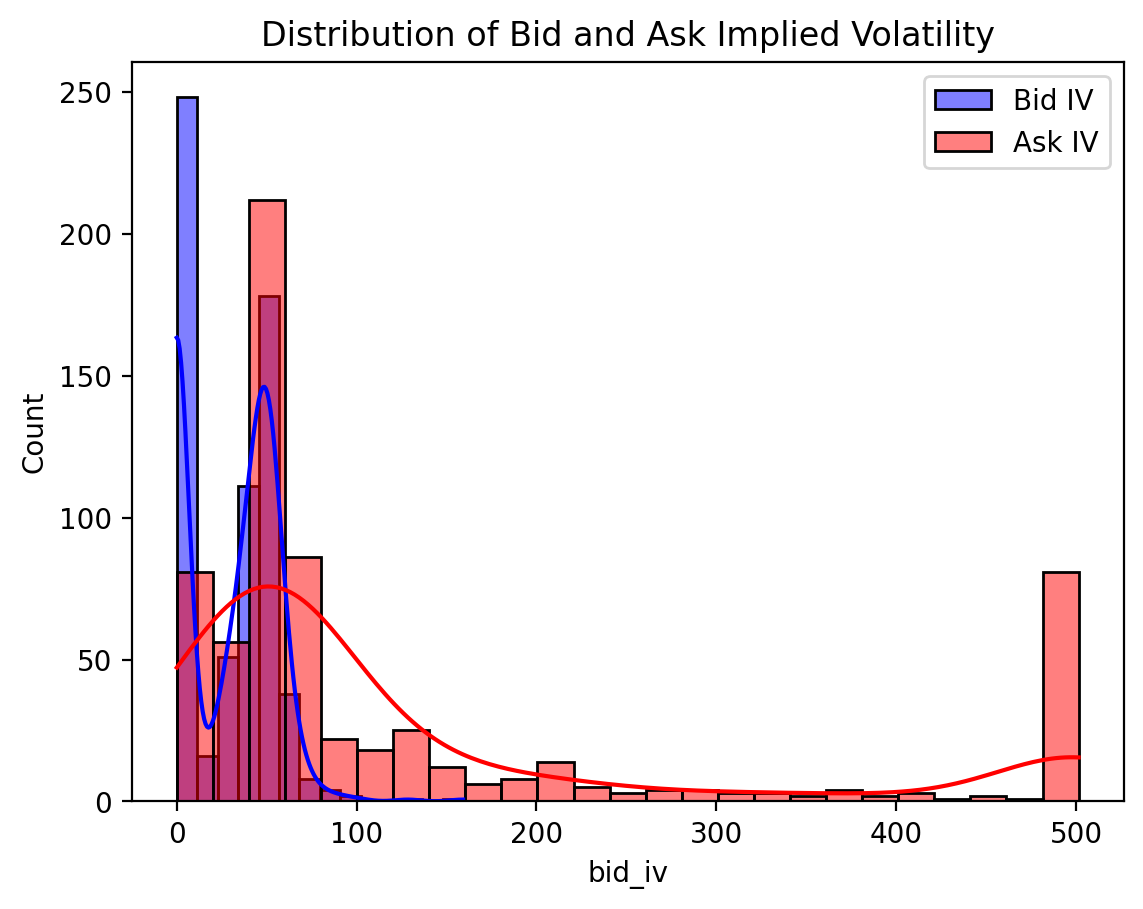

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['bid_iv'].dropna(), color='blue', label='Bid IV', kde=True)
sns.histplot(df['ask_iv'].dropna(), color='red', label='Ask IV', kde=True)
plt.legend()
plt.title('Distribution of Bid and Ask Implied Volatility')
plt.show()


The majority of Bid and Ask IV values are concentrated around lower figures, with a significant peak close to zero. This suggests that many options are perceived to have low volatility, but there is also a noticeable tail extending towards higher values.

In [14]:
median_bid_iv = df['bid_iv'].median()
median_ask_iv = df['ask_iv'].median()
print(f"Median Bid IV: {median_bid_iv}, Median Ask IV: {median_ask_iv}")


Median Bid IV: 36.11, Median Ask IV: 57.724999999999994


### Correlation 

In [15]:
import pandas as pd
import numpy as np

num_data = df.select_dtypes(include=['int64', 'float64'])
corr = num_data.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

c:\Users\Ethan Vaz Falcao\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\io\formats\style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\Ethan Vaz Falcao\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\io\formats\style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,best_ask_amount,bid_iv,ask_iv,underlying_price,mark_iv,interest_rate,best_bid_price,best_ask_price,open_interest,max_price,min_price,last_price,settlement_price,mark_price,index_price,change_id,timestamp,greeks.rho,greeks.theta,greeks.vega,greeks.gamma,greeks.delta,stats.volume_usd,stats.volume,stats.price_change,stats.low,stats.high
best_ask_amount,1.000000,0.016745,-0.144741,-0.183048,-0.064018,nan,-0.072228,-0.136192,0.090288,-0.127477,-0.089553,-0.134875,-0.125205,-0.117707,-0.172307,0.135794,-0.157435,0.121672,-0.030637,-0.152032,-0.010117,0.152903,-0.039535,-0.001624,-0.064068,-0.187836,-0.199457
bid_iv,0.016745,1.000000,-0.059677,0.514686,0.108177,nan,0.251264,0.057091,0.189287,-0.147231,-0.119750,-0.225346,-0.172635,-0.145281,0.206829,0.238944,0.536714,0.025671,0.180267,0.479187,-0.201170,0.016971,-0.022794,-0.044186,0.122927,-0.104442,-0.145848
ask_iv,-0.144741,-0.059677,1.000000,0.219566,0.223759,nan,0.430504,0.859234,-0.035866,0.411163,0.087602,0.514296,0.431212,0.430373,0.155061,0.171372,0.198191,-0.132927,0.174349,0.101417,-0.150335,-0.020483,0.000298,-0.064298,0.051252,0.400405,0.435245
underlying_price,-0.183048,0.514686,0.219566,1.000000,0.238409,nan,0.486356,0.413303,0.061688,0.375349,0.234508,0.384213,0.362152,0.379916,0.585828,0.126106,0.894276,-0.248254,0.283323,0.831123,-0.285221,0.029431,0.070951,-0.082413,0.059051,0.428734,0.428490
mark_iv,-0.064018,0.108177,0.223759,0.238409,1.000000,nan,0.100212,0.194321,0.012029,0.341351,0.184911,0.326374,0.334570,0.353842,-0.006401,0.144640,0.316466,-0.063961,0.501018,0.030641,-0.532993,0.048456,-0.083928,-0.260484,0.179837,0.329225,0.290251
interest_rate,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
best_bid_price,-0.072228,0.251264,0.430504,0.486356,0.100212,nan,1.000000,0.679945,0.031840,0.559357,0.304952,0.605172,0.549114,0.556831,0.250813,0.106574,0.470762,-0.315643,0.161049,0.394908,-0.163901,0.007396,0.047594,-0.060736,0.006356,0.621579,0.597660
best_ask_price,-0.136192,0.057091,0.859234,0.413303,0.194321,nan,0.679945,1.000000,-0.004019,0.621122,0.254891,0.677843,0.625440,0.631390,0.202079,0.119410,0.418636,-0.342011,0.205795,0.317871,-0.185975,-0.102635,0.050579,-0.075498,0.026891,0.660975,0.670793
open_interest,0.090288,0.189287,-0.035866,0.061688,0.012029,nan,0.031840,-0.004019,1.000000,-0.028971,-0.030203,-0.053137,-0.039736,-0.027588,-0.146719,0.064767,0.127935,0.029330,0.064360,0.066815,-0.061082,0.055040,-0.013104,-0.008637,0.455776,-0.094276,-0.106714
max_price,-0.127477,-0.147231,0.411163,0.375349,0.341351,nan,0.559357,0.621122,-0.028971,1.000000,0.806465,0.961876,0.994404,0.994531,0.164390,0.021134,0.403109,-0.609471,0.263910,0.195955,-0.219313,-0.147607,0.155635,-0.085579,0.014930,0.958345,0.940832


In [16]:
btc_data = df

### Options Greeks Visualization

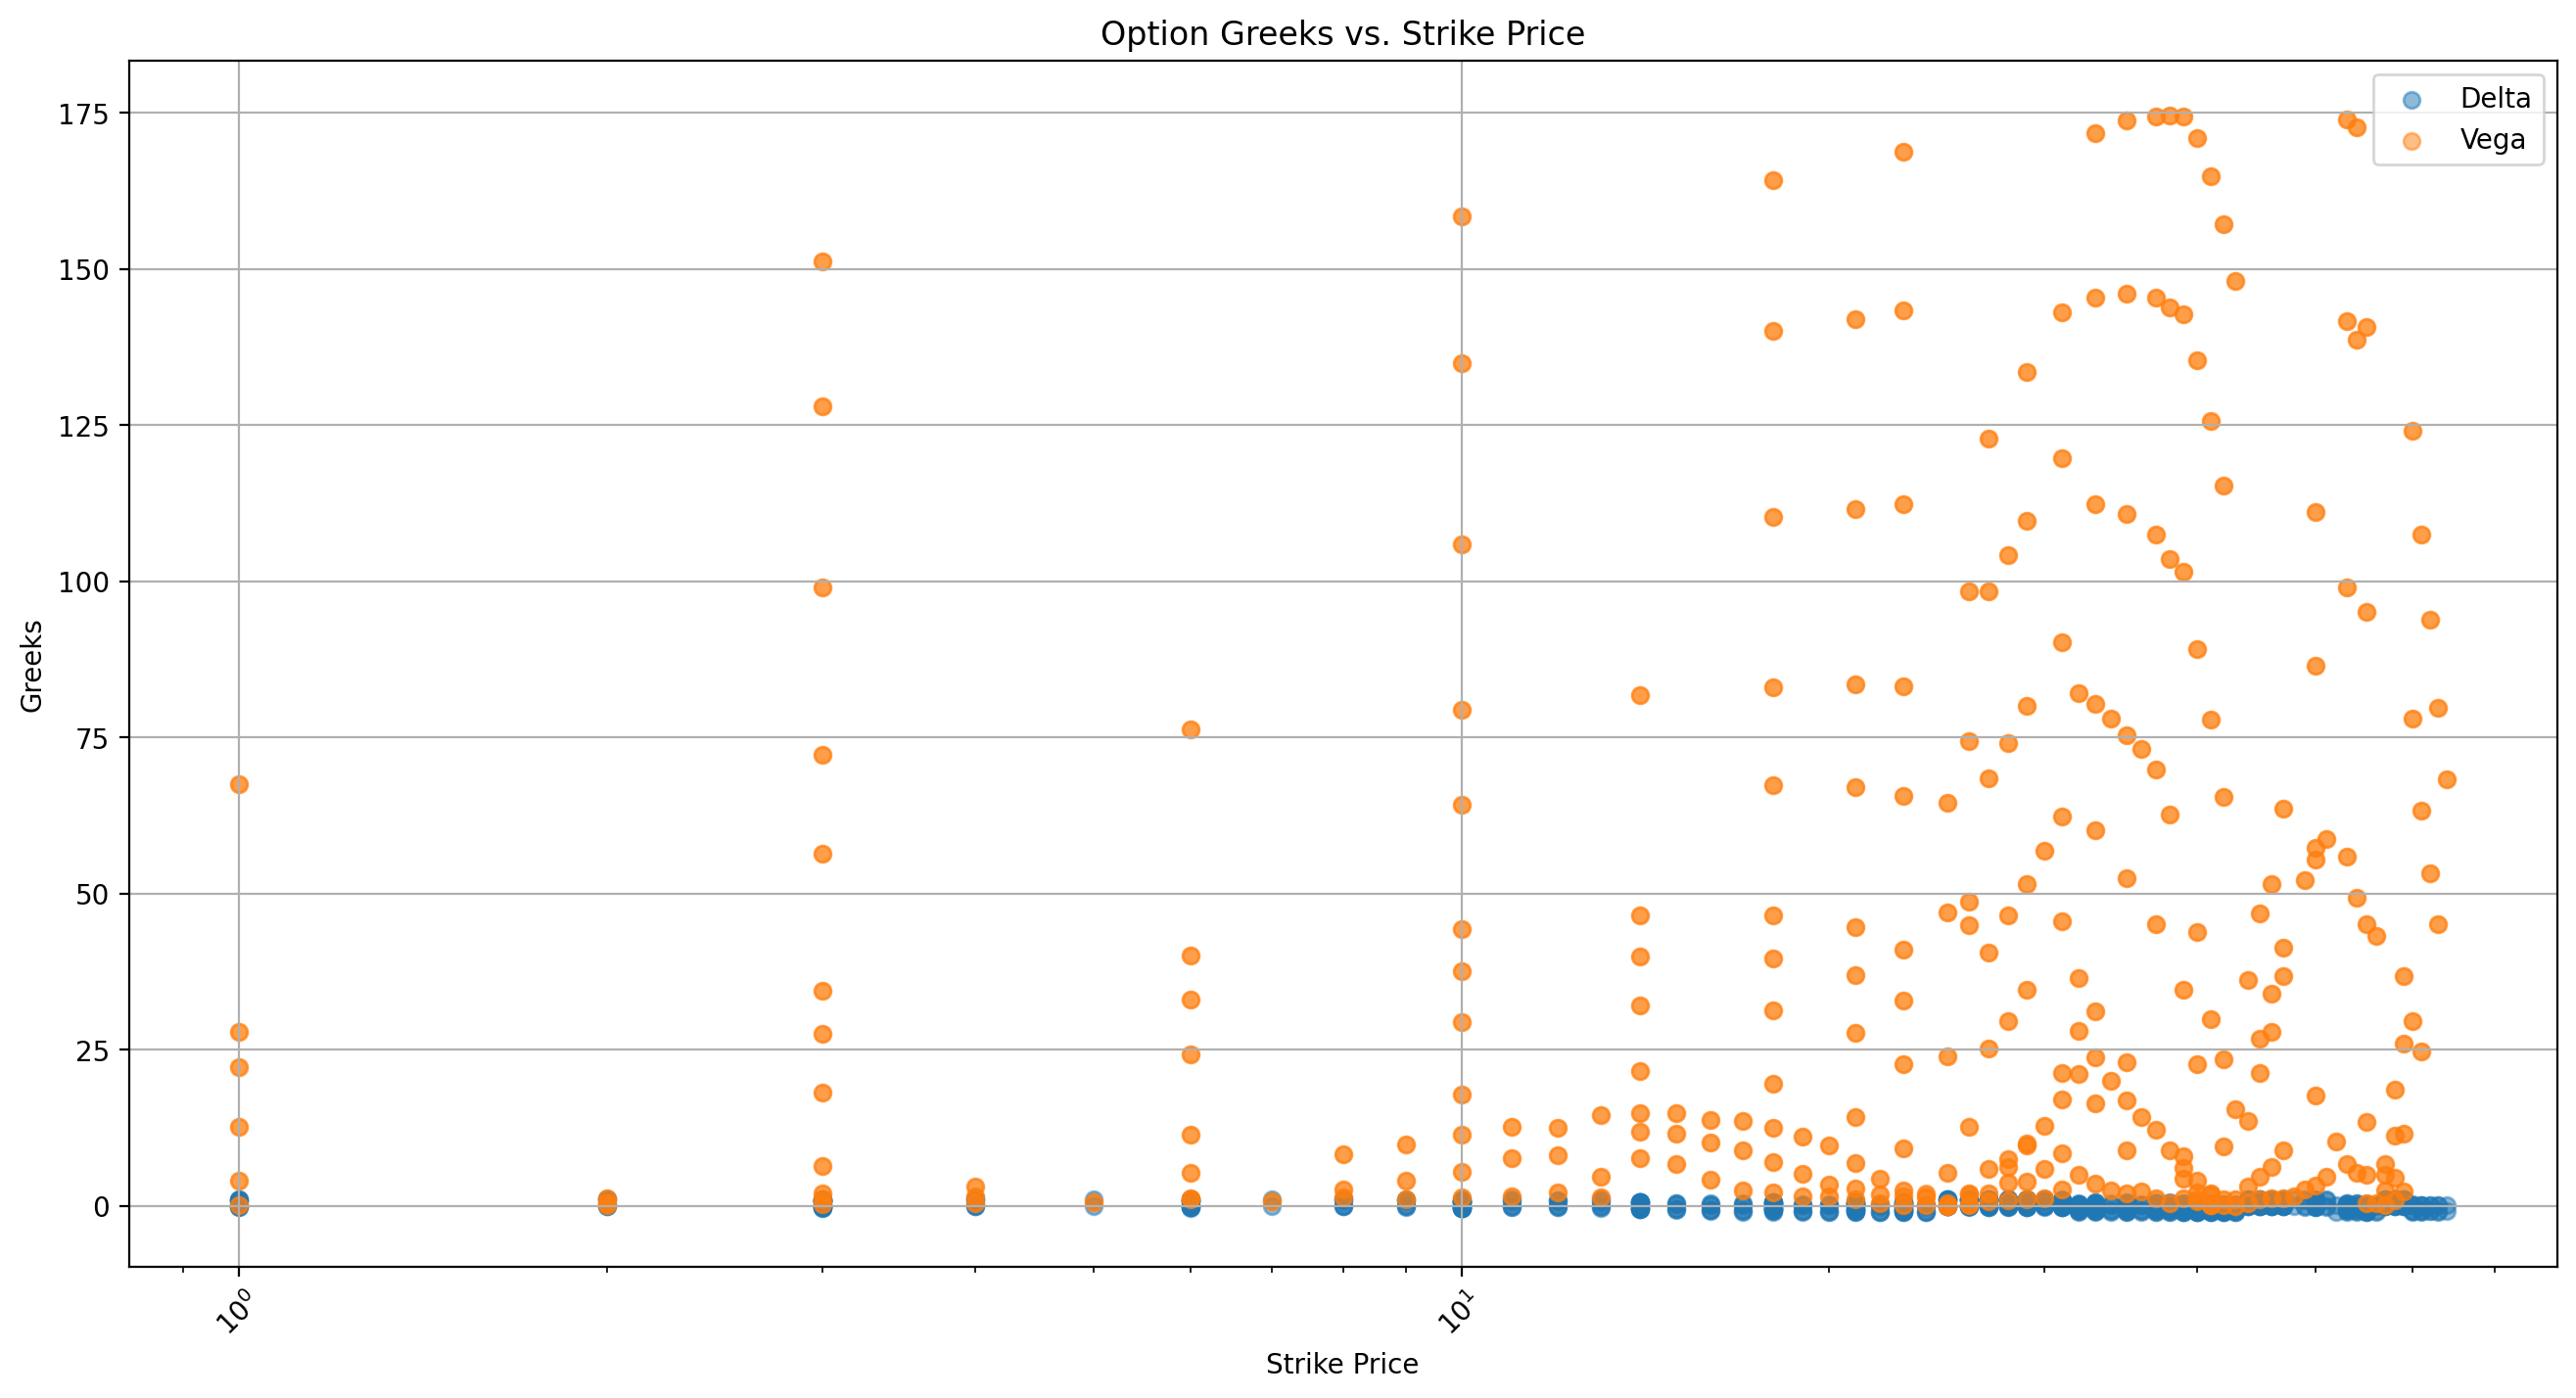

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))  # Larger figure size
plt.scatter(df['Strike Price'], df['greeks.delta'], label='Delta', alpha=0.5)
plt.scatter(df['Strike Price'], df['greeks.vega'], label='Vega', alpha=0.5)
plt.title('Option Greeks vs. Strike Price')
plt.xlabel('Strike Price')
plt.ylabel('Greeks')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.xscale('log')  # Optional: Only use if appropriate for your data range
plt.grid(True)  # Enable grid for better readability
plt.legend()
plt.show()


### Distribution of Returns

In [18]:
# Comparing theoretical and actual prices
btc_data['Theoretical_Price'] = btc_data.apply(lambda x: black_scholes_call(x['underlying_price'], x['Strike Price'], x['Time to Expiration'], 0.01, x['bid_iv']/100), axis=1)

plt.figure(figsize=(12, 6))
plt.plot(btc_data['Date'], btc_data['Theoretical_Price'], label='Theoretical Price')
plt.plot(btc_data['Date'], btc_data['Close'], label='Actual Market Price', alpha=0.6)
plt.title('Theoretical vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


NameError: name 'black_scholes_call' is not defined

In [ ]:
import requests

def fetch_options_volume(instrument_name):
    url = f'https://www.deribit.com/api/v2/public/get_book_summary_by_instrument'
    params = {
        'instrument_name': instrument_name,
        'depth': 1  # You might adjust this based on how much data you need
    }
    response = requests.get(url, params=params)
    data = response.json()
    
    if 'result' in data:
        return data['result'][0]['volume']  # Returns the volume of the options
    else:
        raise Exception(f"Failed to fetch data: {data.get('error', 'Unknown Error')}")

# Example usage
instrument_name = 'BTC-25DEC20-50000-C'  # Replace with a valid instrument name
try:
    volume = fetch_options_volume(instrument_name)
    print(f"Volume for {instrument_name}: {volume}")
except Exception as e:
    print(str(e))


Failed to fetch data: {'message': 'Invalid params', 'data': {'param': 'instrument_name', 'reason': 'instrument is not open'}, 'code': -32602}


In [ ]:
from datetime import datetime

# Assuming 'Expiration Date' is in 'DDMMMYY' format
df['Expiration Date'] = pd.to_datetime(df['Expiration Date'], format='%d%b%y')

# Calculate the time to expiration in years
df['Time to Expiration'] = (df['Expiration Date'] - datetime.now()).dt.days / 365

# Example to calculate one option price using Black-Scholes (use median_iv as placeholder for both bid and ask)
from scipy.stats import norm
import numpy as np

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Select a sample option to price
sample_option = df.iloc[0]
S = sample_option['underlying_price']
K = sample_option['Strike Price']
T = sample_option['Time to Expiration']
r = 0.01  # Approximate risk-free rate
sigma = median_bid_iv / 100  # Convert percentage to decimal

call_price = black_scholes_call(S, K, T, r, sigma)
print(f"Calculated Black-Scholes Call Price: {call_price}")


TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

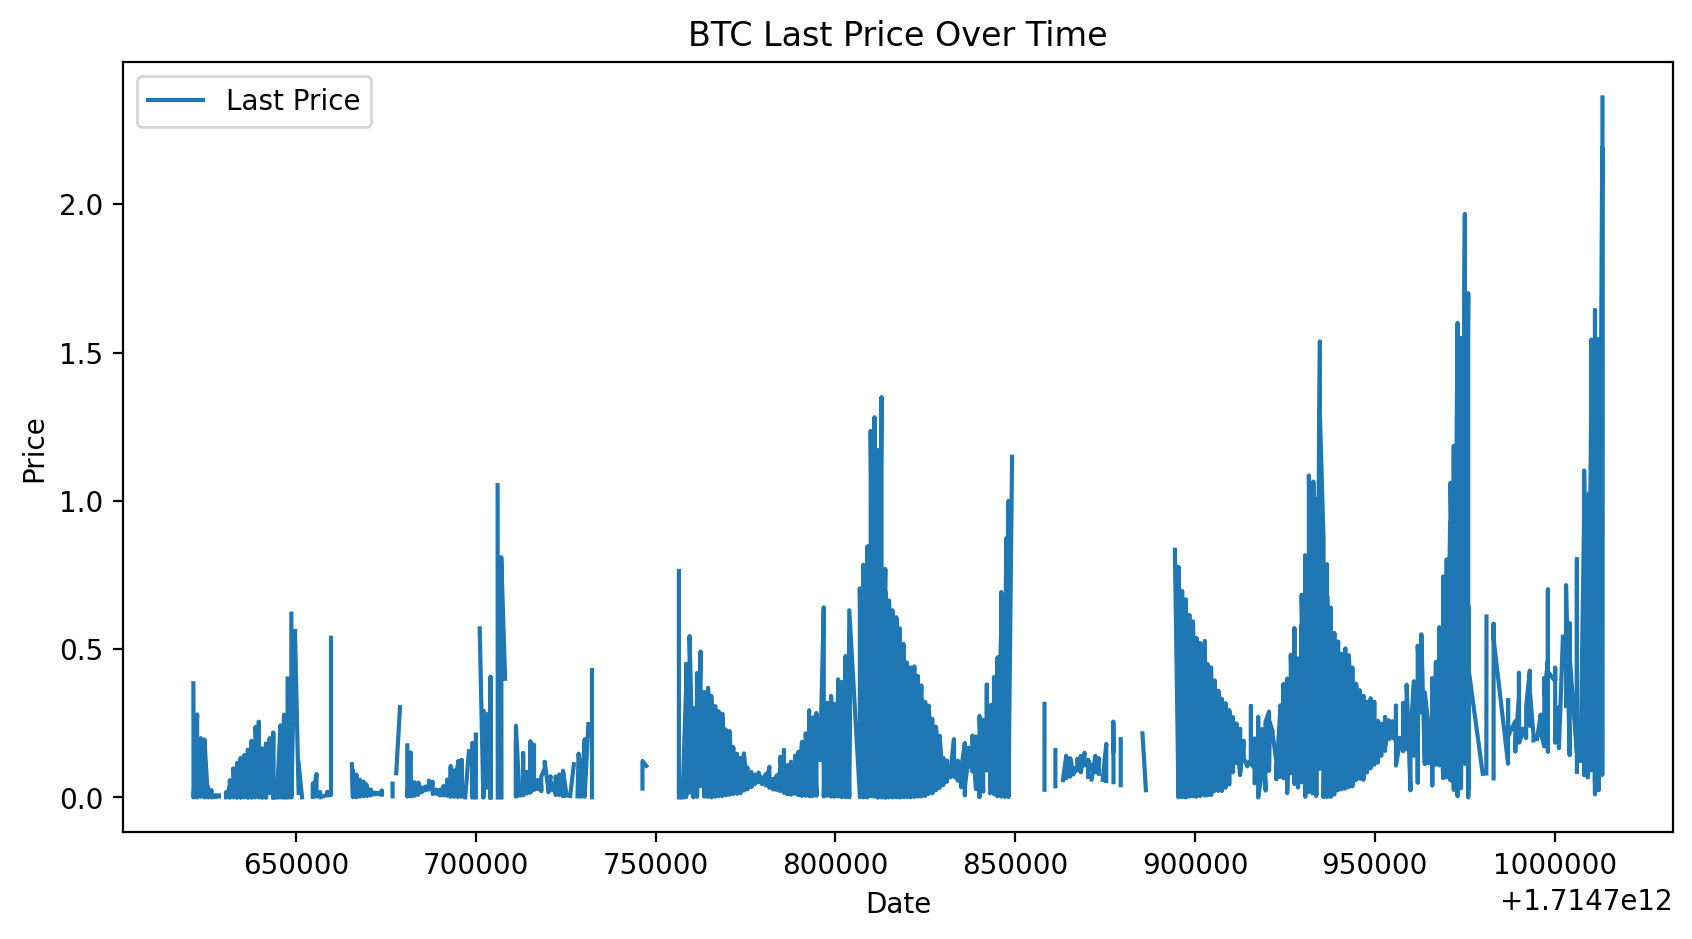

ValueError: could not convert string to float: 'BTC-3MAY24'

<Figure size 1000x800 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the closing price over time
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['last_price'], label='Last Price')
plt.title('BTC Last Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


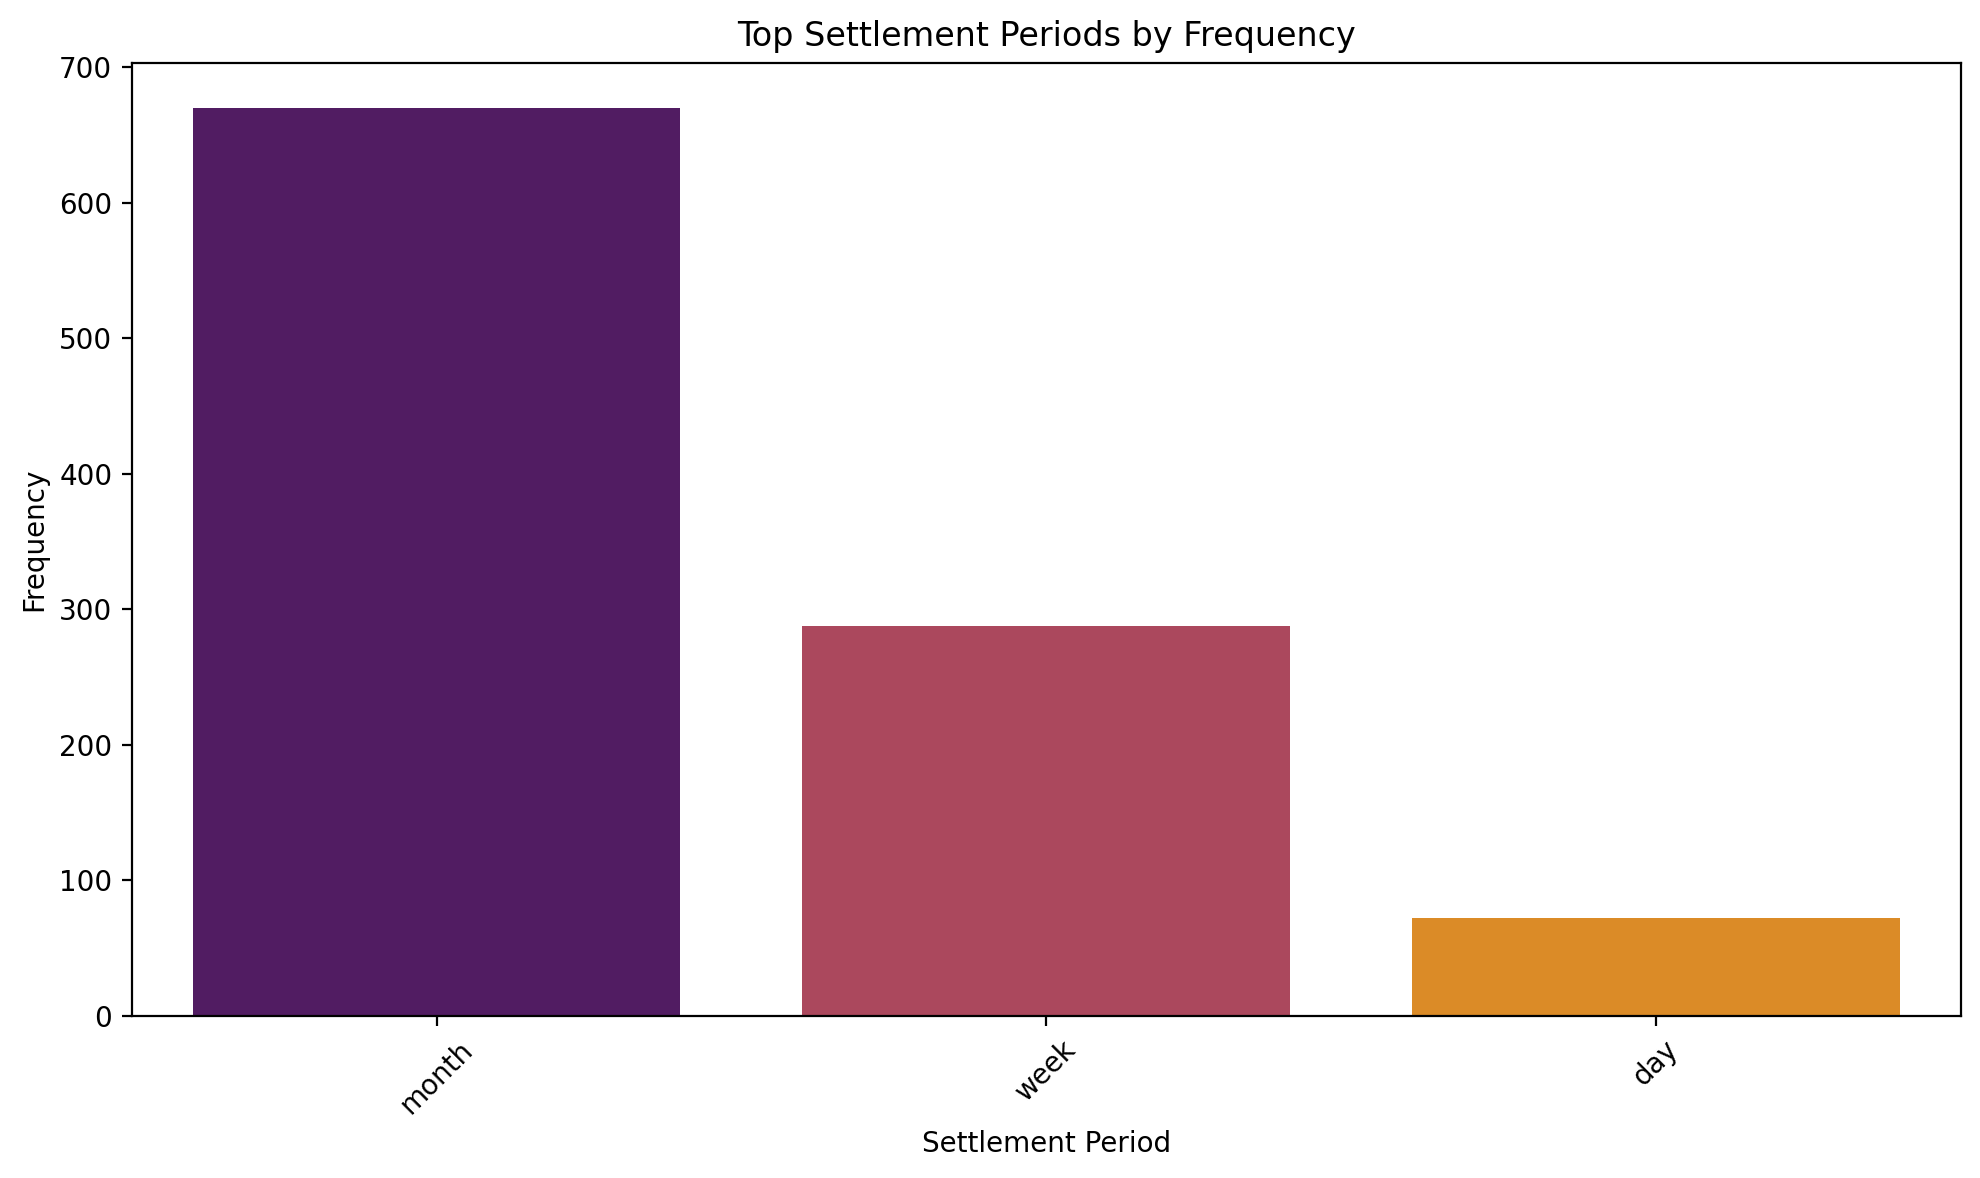

In [ ]:
# Compute the frequency of each unique settlement period
btc_settlement_freq = df['settlement_period'].value_counts().reset_index()
btc_settlement_freq.columns = ['settlement_period', 'Frequency']  # Renaming columns appropriately

# Creating a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='settlement_period', y='Frequency', data=btc_settlement_freq, palette="inferno")
plt.xticks(rotation=45)
plt.xlabel('Settlement Period')
plt.ylabel('Frequency')
plt.title('Top Settlement Periods by Frequency')
plt.tight_layout()
plt.show()

### Distribution 

In [ ]:
ir=df['interest_rate']
ir.describe()

count    1030.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: interest_rate, dtype: float64

## Correlation

In [ ]:
import pandas as pd
import numpy as np

num_data = df.select_dtypes(include=['int64', 'float64'])
corr = num_data.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

,best_bid_amount,best_ask_amount,bid_iv,ask_iv,underlying_price,mark_iv,best_bid_price,best_ask_price,open_interest,max_price,min_price,last_price,settlement_price,mark_price,index_price,change_id,timestamp,greeks.rho,greeks.theta,greeks.vega,greeks.gamma,greeks.delta,stats.volume_usd,stats.volume,stats.price_change,stats.low,stats.high
best_bid_amount,1.000000,0.272543,0.014559,-0.011954,0.034158,-0.055853,0.045808,0.085703,0.037725,0.014612,-0.005632,-0.009563,-0.004528,-0.016192,0.097655,0.039849,-0.119664,0.032766,-0.184346,-0.146322,0.042671,0.009243,0.015931,0.018107,-0.024624,0.088392,0.066286
best_ask_amount,0.272543,1.000000,0.003644,0.091215,0.180338,-0.184907,0.067065,0.202010,0.007295,0.054128,-0.044528,-0.063962,-0.015114,-0.031592,0.273358,0.074072,-0.340396,0.026556,-0.296572,-0.276277,0.120102,-0.155406,-0.011891,0.054300,-0.042284,-0.070283,-0.084860
bid_iv,0.014559,0.003644,1.000000,-0.119055,-0.058624,-0.138004,0.037531,-0.061777,0.056681,-0.149284,-0.147279,-0.097303,-0.180109,-0.157930,-0.014961,0.075157,-0.008077,0.088139,-0.081310,-0.025548,0.016141,0.124410,0.487974,0.554886,0.011028,-0.059635,0.035974
ask_iv,-0.011954,0.091215,-0.119055,1.000000,0.307028,0.305881,-0.027171,0.142988,0.035149,-0.166477,-0.120897,-0.124477,-0.133431,-0.132225,0.368757,0.088751,-0.401486,0.121175,0.139656,-0.347766,-0.097729,-0.039555,-0.068284,-0.055495,0.164752,-0.130307,-0.155935
underlying_price,0.034158,0.180338,-0.058624,0.307028,1.000000,0.090441,-0.250090,-0.214028,-0.130046,-0.020514,-0.150854,-0.142954,-0.116553,-0.152672,0.516460,-0.081639,-0.610695,0.042923,-0.272998,-0.296734,0.211076,-0.050469,0.093844,0.161835,0.072596,-0.167070,-0.148294
mark_iv,-0.055853,-0.184907,-0.138004,0.305881,0.090441,1.000000,0.012272,0.132110,-0.093063,0.161993,0.250512,0.240849,0.238205,0.245483,0.053311,0.072454,0.079763,-0.069214,0.226428,-0.033428,-0.439793,-0.082540,-0.047736,-0.165896,0.072408,0.210313,0.189890
best_bid_price,0.045808,0.067065,0.037531,-0.027171,-0.250090,0.012272,1.000000,0.667777,0.061480,0.459902,0.463080,0.470482,0.471835,0.485546,-0.209857,0.049931,0.252356,-0.350421,0.096584,0.102894,-0.079548,-0.145842,-0.000382,-0.048572,-0.030210,0.466249,0.441105
best_ask_price,0.085703,0.202010,-0.061777,0.142988,-0.214028,0.132110,0.667777,1.000000,0.063920,0.554909,0.588629,0.597627,0.602842,0.600400,-0.115452,0.057432,0.187072,-0.308634,0.159160,-0.014894,-0.113433,-0.182082,-0.017352,-0.059204,-0.023118,0.601626,0.557184
open_interest,0.037725,0.007295,0.056681,0.035149,-0.130046,-0.093063,0.061480,0.063920,1.000000,-0.136198,-0.057678,-0.082254,-0.083174,-0.074600,0.036401,0.061071,0.012626,0.071618,0.165880,-0.110186,-0.069989,0.016939,-0.027687,-0.019316,0.005135,-0.043281,-0.062479
max_price,0.014612,0.054128,-0.149284,-0.166477,-0.020514,0.161993,0.459902,0.554909,-0.136198,1.000000,0.919373,0.898553,0.954717,0.952191,-0.206813,-0.069002,0.250077,-0.723589,0.021779,0.118461,-0.046615,-0.399419,0.213014,-0.000857,-0.062552,0.897261,0.893357
